In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import random
from IPython import display
from sklearn import datasets, preprocessing

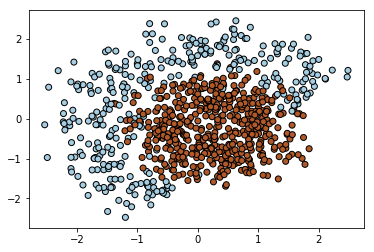

In [21]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = (y==1) | (X[:,1] > X[:,0] - 0.5)

X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
plt.show()

X, y = torch.FloatTensor(X), torch.FloatTensor(y)

In [22]:
import numpy as np

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, loss, n_iter):    
    plt.clf()
    xy = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    Z = classify(xy, w)
    
    Z = Z.numpy()
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [74]:
def expand(X):
    prod = X[:,0] * X[:,1]
    prod = prod.unsqueeze(1)
    oness = torch.ones_like(X[:, 0])
    oness = oness.unsqueeze(1)
    res = torch.cat([X, X ** 2, prod, oness], dim=1)
    return torch.FloatTensor(res)

def classify(X, w):
    """
    Given feature matrix X [n_samples,2] and weight vector w [6],
    return an array of +1 or -1 predictions
    """
    X_ = expand(X)
    return torch.mv(X_, w).sign()

In [110]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute Hinge loss.
    """
    X_ = expand(X)
    n = X_.size()[0]
    return (1 - torch.mul(torch.mv(X_, w), y)) \
               .max(torch.zeros(n)) \
               .mean()


def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    X_ = expand(X)
    n = X_.size()[0]
    grads = torch.where(
        torch.mul(y, torch.mv(X_, w)) < 1,
        -torch.mul(X_.t(), y),
        torch.zeros_like(X_.t())
    )
    return grads.mean(dim=1)

torch.Size([6])


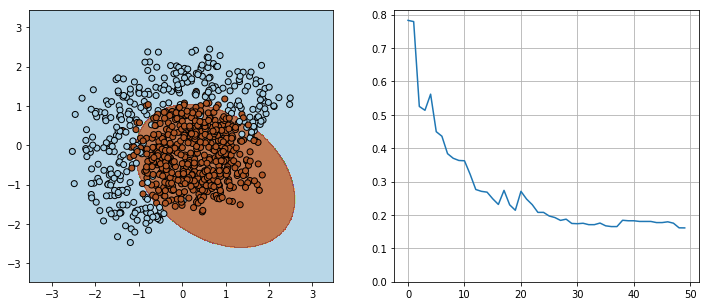

<Figure size 864x360 with 0 Axes>

In [156]:
w = torch.Tensor([1, 0, 0, 0, 0, 0])

alpha = 0.3

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    # visualize(X[ind,:], y[ind], w, loss, n_iter)
    
    w = w - alpha * compute_grad(X[ind,:], y[ind], w)

print(w.shape)
visualize(X, y, w, loss, n_iter)
plt.clf()

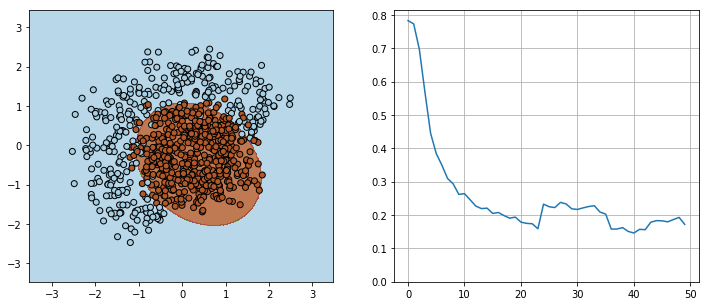

<Figure size 864x360 with 0 Axes>

In [157]:
w = torch.Tensor([1, 0, 0, 0, 0, 0])

alpha =  0.25 # learning rate
mu    =  0.5  # momentum

v = torch.zeros_like(w)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    # visualize(X[ind,:], y[ind], w, loss, n_iter)
    grad = compute_grad(X[ind,:], y[ind], w)
    v = mu * v - alpha * grad
    w = w + v

visualize(X, y, w, loss, n_iter)
plt.clf()

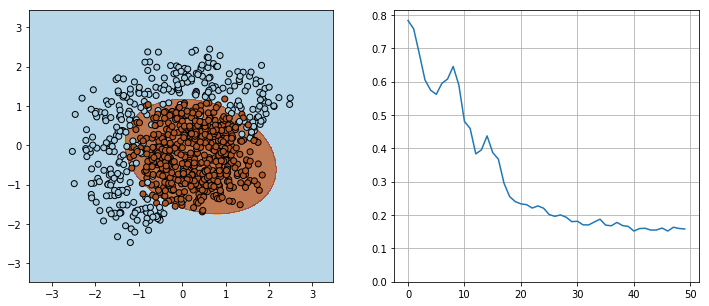

<Figure size 864x360 with 0 Axes>

In [158]:
w = torch.Tensor([1, 0, 0, 0, 0, 0])

alpha = 0.2 # learning rate
mu    = 0.5  # momentum

v = torch.zeros_like(w)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
#     visualize(X[ind,:], y[ind], w, loss, n_iter)
    grad = compute_grad(X[ind,:], y[ind], w + mu * v)
    v = mu * v - alpha * grad
    w = w + v

visualize(X, y, w, loss, n_iter)
plt.clf()

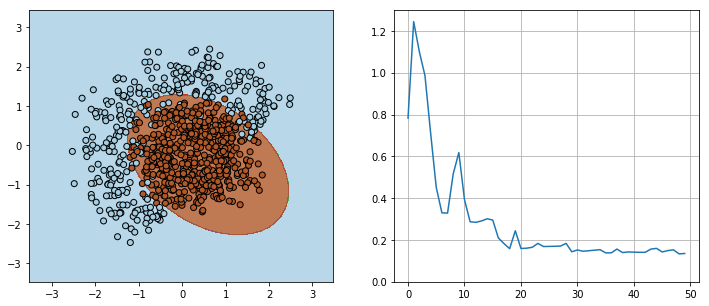

<Figure size 864x360 with 0 Axes>

In [164]:
w = torch.Tensor([1, 0, 0, 0, 0, 0])

alpha = 0.25   # learning rate
beta  = 0.9   # (beta1 coefficient in original paper) exponential decay rate for the 1st moment estimates
mu    = 0.999 # (beta2 coefficient in original paper) exponential decay rate for the 2nd moment estimates
eps   = 1e-9  # A small constant for numerical stability

v = torch.zeros_like(w)
g = torch.zeros_like(w)


n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    # visualize(X[ind,:], y[ind], w, loss, n_iter)
    grad = compute_grad(X[ind,:], y[ind], w)
    g = beta * v + (1 - beta) * grad
    v = mu * v  + (1 - mu) * (grad ** 2)
    w = w - alpha / (torch.sqrt(v) + eps) * g

visualize(X, y, w, loss, n_iter)
plt.clf()